In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os,sys,copy
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from cycler import cycler
import tensorflow as tf
from tensorflow.keras import layers
import seaborn
import seaborn as sns
import pandas as pd
import datetime
from imdb import IMDb
from mediawikiapi import MediaWikiAPI
from tqdm import tqdm

In [3]:
color_cycle_wong = ['#000000','#E69F00','#CC79A7','#56B4E9','#009E73','#0072B2','#F0E442','#D55E00']
Six_color_cycle = ["#5790FC", "#F89C20", "#E42536", "#964A8B", "#9C9CA1", "#7A21DD"]
Eight_color_cycle = ["#1845FB", "#FF5E02", "#C91F16", "#C849A9", "#ADAD7D", "#86C8DD", "#578DFF", "#656364"]
Ten_color_cycle = ["#3F90DA", "#FFA90E", "#BD1F01", "#94A4A2", "#832DB6", "#A96B59", "#E76300", "#B9AC70", "#717581", "#92DADD"]
mpl.rcParams['axes.prop_cycle'] = cycler(color=Six_color_cycle)

In [4]:
interesting_parameters = ['title','genres','year','languages','votes','runtimes','rating']

In [5]:
save_data_file = './Misc_Files/imdb_movie_selection_v1.npy'
loaded_data = np.load(save_data_file,allow_pickle=True)
movie_features = pd.DataFrame(loaded_data,columns=interesting_parameters)

In [6]:
movie_features

,title,genres,year,languages,votes,runtimes,rating
0,Tuscan Wedding,Comedy,2014,English,1790,104,5.2
1,The Four of the Apocalypse...,Fantasy,1975,Italian,2485,104,6.4
2,Knuckleball!,Documentary,2012,English,1686,93,7.1
3,The Farewell,Comedy,2019,Mandarin,56213,100,7.6
4,Johnny in the Clouds,Drama,1945,English,1441,109,7.3
...,...,...,...,...,...,...,...
5697,Summer Lovers,Comedy,1982,English,3971,98,5.7
5698,Matchstick Men,Comedy,2003,English,126764,116,7.3
5699,Sands of Iwo Jima,Action,1949,English,10065,100,7.1
5700,The Nutcracker,Family,1993,English,1968,92,5.8


In [7]:
for name, column in movie_features.items():
    if name in ['year','votes','runtimes','rating']:
        movie_features[name] = movie_features[name].astype(float)
    else:
        movie_features[name] = movie_features[name].astype(str)

In [8]:
movie_features

,title,genres,year,languages,votes,runtimes,rating
0,Tuscan Wedding,Comedy,2014.0,English,1790.0,104.0,5.2
1,The Four of the Apocalypse...,Fantasy,1975.0,Italian,2485.0,104.0,6.4
2,Knuckleball!,Documentary,2012.0,English,1686.0,93.0,7.1
3,The Farewell,Comedy,2019.0,Mandarin,56213.0,100.0,7.6
4,Johnny in the Clouds,Drama,1945.0,English,1441.0,109.0,7.3
...,...,...,...,...,...,...,...
5697,Summer Lovers,Comedy,1982.0,English,3971.0,98.0,5.7
5698,Matchstick Men,Comedy,2003.0,English,126764.0,116.0,7.3
5699,Sands of Iwo Jima,Action,1949.0,English,10065.0,100.0,7.1
5700,The Nutcracker,Family,1993.0,English,1968.0,92.0,5.8


# Data Exploration

array([[<AxesSubplot:title={'center':'year'}>,
        <AxesSubplot:title={'center':'votes'}>],
       [<AxesSubplot:title={'center':'runtimes'}>,
        <AxesSubplot:title={'center':'rating'}>]], dtype=object)

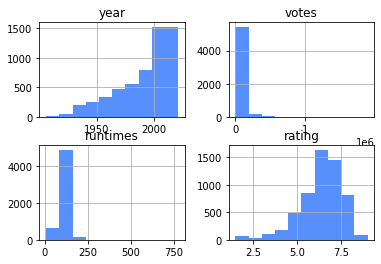

In [9]:
pd.DataFrame.hist(movie_features)

Text(0.5, 1.0, 'imdb_score')

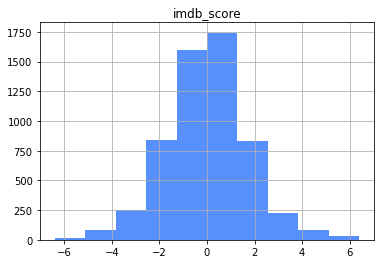

In [10]:
movie_features['rating'].diff().hist()
plt.title("imdb_score")

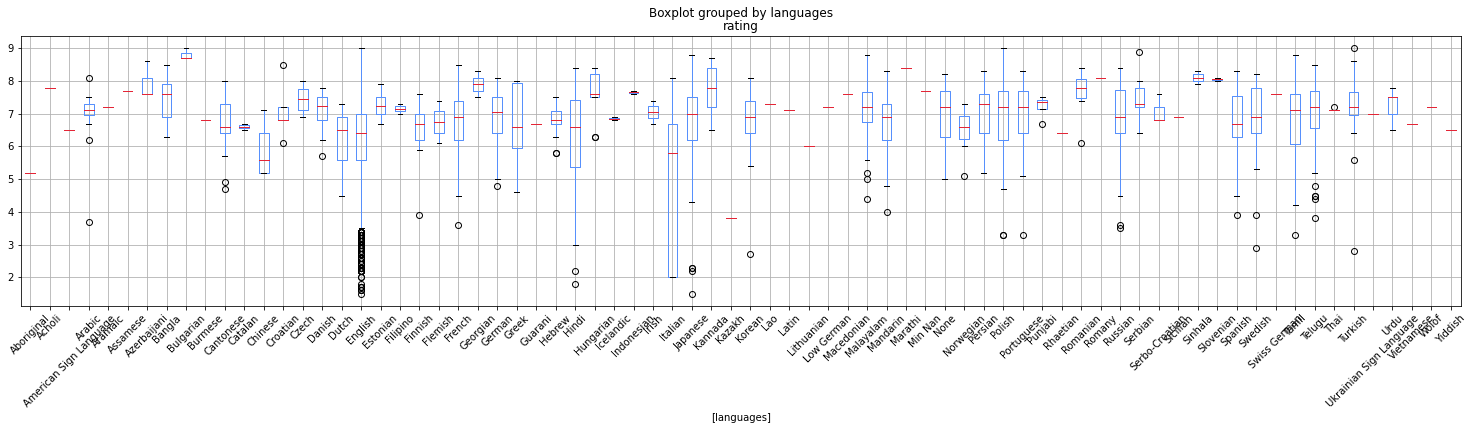

In [11]:
#imdb score vs country
df = movie_features[['languages','rating']]
df.boxplot(by='languages',rot=45,figsize=(25,5))
plt.show()

In [12]:
movie_features.keys()

Index(['title', 'genres', 'year', 'languages', 'votes', 'runtimes', 'rating'], dtype='object')

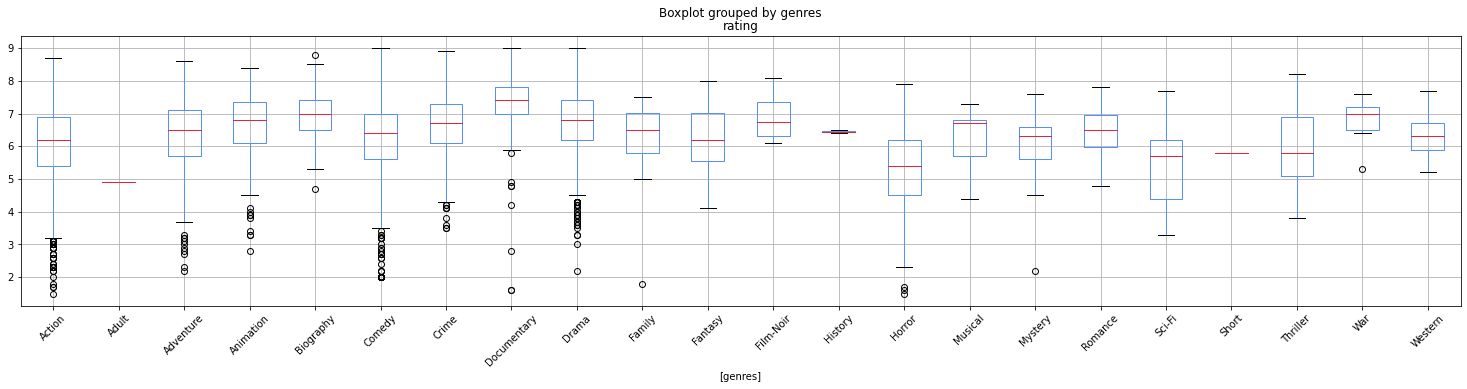

In [13]:
#imdb score vs country
df = movie_features[['genres','rating']]
df.boxplot(by='genres',rot=45,figsize=(25,5))
plt.show()

<AxesSubplot:xlabel='year', ylabel='rating'>

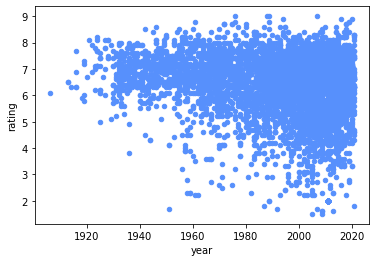

In [14]:
movie_features.plot.scatter('year','rating')

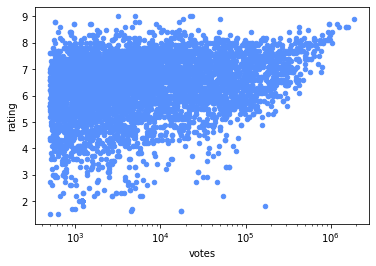

In [15]:
movie_features.plot.scatter('votes','rating')
plt.xscale('log')
plt.show()

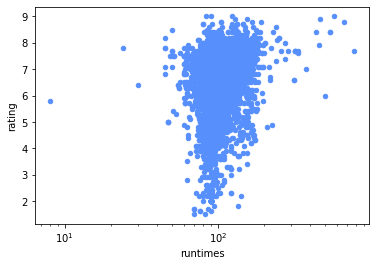

In [16]:
movie_features.plot.scatter('runtimes','rating')
plt.xscale('log')
plt.show()

<ipython-input-17-f68ea7640d8d>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  seaborn.heatmap(movie_features.corr())


<AxesSubplot:>

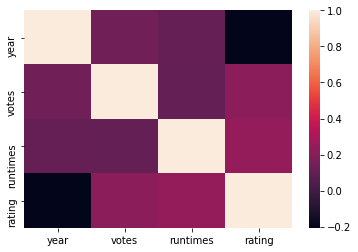

In [17]:
seaborn.heatmap(movie_features.corr())

In [18]:
data = copy.deepcopy(movie_features)

In [19]:
for dk in data.keys():
    if isinstance(data[dk][0],str):
        uniques = np.unique(data[dk])
        mapping = {}
        i = 0
        for uni in uniques:
            mapping[uni] = i
            i +=1
        data[dk] = data[dk].map(mapping)

In [20]:
data

,title,genres,year,languages,votes,runtimes,rating
0,4225,5,2014.0,17,1790.0,104.0,5.2
1,3432,10,1975.0,33,2485.0,104.0,6.4
2,1645,7,2012.0,17,1686.0,93.0,7.1
3,3411,5,2019.0,44,56213.0,100.0,7.6
4,1494,8,1945.0,17,1441.0,109.0,7.3
...,...,...,...,...,...,...,...
5697,3060,5,1982.0,17,3971.0,98.0,5.7
5698,1786,5,2003.0,17,126764.0,116.0,7.3
5699,2722,0,1949.0,17,10065.0,100.0,7.1
5700,3635,9,1993.0,17,1968.0,92.0,5.8


In [21]:
movie_labels = movie_features.pop('rating')

From this tutorial: https://www.tensorflow.org/tutorials/load_data/csv

In [22]:
movie_features

,title,genres,year,languages,votes,runtimes
0,Tuscan Wedding,Comedy,2014.0,English,1790.0,104.0
1,The Four of the Apocalypse...,Fantasy,1975.0,Italian,2485.0,104.0
2,Knuckleball!,Documentary,2012.0,English,1686.0,93.0
3,The Farewell,Comedy,2019.0,Mandarin,56213.0,100.0
4,Johnny in the Clouds,Drama,1945.0,English,1441.0,109.0
...,...,...,...,...,...,...
5697,Summer Lovers,Comedy,1982.0,English,3971.0,98.0
5698,Matchstick Men,Comedy,2003.0,English,126764.0,116.0
5699,Sands of Iwo Jima,Action,1949.0,English,10065.0,100.0
5700,The Nutcracker,Family,1993.0,English,1968.0,92.0


In [23]:
type(movie_labels[0])

numpy.float64

In [24]:
innputs = {}

for name, column in movie_features.items():
    dtype = type(column[0])
    if isinstance(column[0],str):
        dtype = tf.string
    else:
        dtype = tf.float32

    innputs[name] = tf.keras.Input(shape=(1,), name=name, dtype=dtype)

innputs

{'title': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'title')>,
 'genres': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'genres')>,
 'year': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'year')>,
 'languages': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'languages')>,
 'votes': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'votes')>,
 'runtimes': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'runtimes')>}

In [25]:
numeric_innputs = {name:innput for name,innput in innputs.items()
                  if innput.dtype==tf.float32}

x = layers.Concatenate()(list(numeric_innputs.values()))
norm = layers.Normalization()
norm.adapt(np.array(movie_features[numeric_innputs.keys()]))
all_numeric_innputs = norm(x)

all_numeric_innputs

<KerasTensor: shape=(None, 3) dtype=float32 (created by layer 'normalization')>

In [26]:
preprocessed_innputs = [all_numeric_innputs]

In [27]:
for name, innput in innputs.items():
    if innput.dtype == tf.float32:
        continue

    lookup = layers.StringLookup(vocabulary=np.unique(movie_features[name]))
    one_hot = layers.CategoryEncoding(num_tokens=lookup.vocabulary_size())

    x = lookup(innput)
    x = one_hot(x)
    preprocessed_innputs.append(x)

In [28]:
preprocessed_innputs_cat = layers.Concatenate()(preprocessed_innputs)

movie_preprocessing = tf.keras.Model(innputs, preprocessed_innputs_cat)

tf.keras.utils.plot_model(model = movie_preprocessing , rankdir="LR", dpi=72, show_shapes=True)


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [29]:
movie_features_dict = {name: np.array(value) 
                         for name, value in movie_features.items()}

In [30]:
features_dict = {name:values[:1] for name, values in movie_features_dict.items()}
movie_preprocessing(features_dict)


<tf.Tensor: shape=(1, 4861), dtype=float32, numpy=
array([[ 0.93865615, -0.33837774, -0.05587191, ...,  0.        ,
         0.        ,  0.        ]], dtype=float32)>

In [34]:
def movie_model(preprocessing_head, innputs):
    body = tf.keras.Sequential([
        layers.Dense(64),
        layers.Dense(1)
    ])

    preprocessed_innputs = preprocessing_head(innputs)
    result = body(preprocessed_innputs)
    model = tf.keras.Model(innputs, result)

    model.compile(loss=tf.keras.losses.MeanSquaredError(),
                  optimizer='adam',
                  #metrics=['accuracy']
                 )
    return model

movie_model = movie_model(movie_preprocessing, innputs)

In [35]:
[print(i.shape, i.dtype) for i in movie_model.inputs]
[print(o.shape, o.dtype) for o in movie_model.outputs]
[print(l.name, l.input_shape, l.dtype) for l in movie_model.layers]

(None, 1) <dtype: 'string'>
(None, 1) <dtype: 'string'>
(None, 1) <dtype: 'float32'>
(None, 1) <dtype: 'string'>
(None, 1) <dtype: 'float32'>
(None, 1) <dtype: 'float32'>
(None, 1) <dtype: 'float32'>
genres [(None, 1)] string
languages [(None, 1)] string
runtimes [(None, 1)] float32
title [(None, 1)] string
votes [(None, 1)] float32
year [(None, 1)] float32
model {'title': (None, 1), 'genres': (None, 1), 'year': (None, 1), 'languages': (None, 1), 'votes': (None, 1), 'runtimes': (None, 1)} float32
sequential_1 (None, 4861) float32


[None, None, None, None, None, None, None, None]

In [36]:
history = movie_model.fit(x=movie_features_dict, y=movie_labels, epochs=10)

Epoch 1/10
179/179 [==============================] - 2s 6ms/step - loss: 13.6744
Epoch 2/10
179/179 [==============================] - 1s 5ms/step - loss: 0.9983
Epoch 3/10
179/179 [==============================] - 1s 5ms/step - loss: 0.6017
Epoch 4/10
179/179 [==============================] - 1s 5ms/step - loss: 0.4034
Epoch 5/10
179/179 [==============================] - 1s 5ms/step - loss: 0.2721
Epoch 6/10
179/179 [==============================] - 1s 5ms/step - loss: 0.1853
Epoch 7/10
179/179 [==============================] - 1s 5ms/step - loss: 0.1230
Epoch 8/10
179/179 [==============================] - 1s 5ms/step - loss: 0.0858
Epoch 9/10
179/179 [==============================] - 1s 5ms/step - loss: 0.0618
Epoch 10/10
179/179 [==============================] - 1s 5ms/step - loss: 0.0448


In [ ]:
from keras.wrappers.scikit_learn import KerasRegressor
from keras.optimizers import SGD
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

In [ ]:
data.shape

In [ ]:
X = data.iloc[:, 0:6].values
Y = data.iloc[:, 6:7].values

In [ ]:
def baseline_model(learn_rate=0.01, momentum=0):
    # create model
    model = tf.keras.Sequential()
    model.add(layers.Dense(6, input_dim=6, kernel_initializer='normal', activation='relu'))
    model.add(layers.Dense(1, kernel_initializer='normal', activation='relu'))
    # compile model
    optimizer = SGD(lr=learn_rate, momentum=momentum)
    model.compile(loss='mean_absolute_error', optimizer='adam')
    return model

In [ ]:
#evaluate base model
np.random.seed(42)
#evaluate model with standardized dataset?
estimator = KerasRegressor(build_fn=baseline_model, nb_epoch=10, batch_size=50, verbose=1)
#using 10-fold cross validation to evaluate the model
kfold = KFold(n_splits=10)
results = cross_val_score(estimator, X, Y, cv=kfold)
print("Results: %.2f (%.2f) MAE" % (results.mean(), results.std()))